# 03 - Training & Evaluation

This notebook covers:
1. Feature Engineering
2. Model Training (RandomForest, XGBoost)
3. Hyperparameter Tuning (GridSearchCV)
4. Model Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Boosting libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import joblib

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

Using device: mps


In [2]:
# Define paths
DATA_PROCESSED = Path('../data/processed')
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# Load cleaned data
df = pd.read_csv(DATA_PROCESSED / 'ratings_cleaned.csv')

print(f"Loaded {len(df):,} ratings")
print(f"Columns: {list(df.columns)}")
df.head()

Loaded 100,357 ratings
Columns: ['userId', 'movieId', 'rating', 'title', 'genres', 'director', 'cast', 'country', 'runtime', 'budget', 'revenue', 'release_date', 'original_language', 'vote_average', 'vote_count', 'popularity', 'tags']


,userId,movieId,rating,title,genres,director,cast,country,runtime,budget,revenue,release_date,original_language,vote_average,vote_count,popularity,tags
0,1,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,John Lasseter,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,US,81.0,30000000.0,394436586.0,1995-11-22,en,7.97,19291.0,18.8275,pixar|pixar|fun
1,1,3,4.0,Grumpier Old Men,Comedy|Romance,Howard Deutch,Walter Matthau|Jack Lemmon|Ann-Margret|Sophia ...,US,101.0,25000000.0,71500000.0,1995-12-22,en,6.50,409.0,2.2075,moldy|old
2,1,6,4.0,Heat,Action|Crime|Thriller,Michael Mann,Al Pacino|Robert De Niro|Val Kilmer|Jon Voight...,US,170.0,60000000.0,187400000.0,1995-12-15,en,7.90,7917.0,11.0379,NaN
3,1,47,5.0,Seven (a.k.a. Se7en),Mystery|Thriller,David Fincher,Morgan Freeman|Brad Pitt|Gwyneth Paltrow|John ...,US,127.0,33000000.0,327311859.0,1995-09-22,en,8.40,22288.0,13.2001,mystery|twist ending|serial killer
4,1,50,5.0,"Usual Suspects, The",Crime|Mystery|Thriller,Bryan Singer,Stephen Baldwin|Gabriel Byrne|Benicio del Toro...,US,106.0,6000000.0,23300000.0,1995-07-19,en,8.20,10965.0,7.8931,mindfuck|suspense|thriller|tricky|twist ending...


---

## Feature Engineering

Create features at multiple levels:
1. **User features** - User behavior patterns
2. **Movie features** - Film characteristics
3. **Interaction features** - User-movie compatibility
4. **Temporal features** - Time-based patterns

### 1. User Features

Capture user rating behavior and preferences.

In [4]:
# Basic user statistics
user_stats = df.groupby('userId').agg(
    user_rating_count=('rating', 'count'),
    user_avg_rating=('rating', 'mean'),
    user_rating_std=('rating', 'std'),
    user_rating_min=('rating', 'min'),
    user_rating_max=('rating', 'max'),
    user_rating_median=('rating', 'median')
).reset_index()

# Fill NaN std (users with only 1 rating)
user_stats['user_rating_std'] = user_stats['user_rating_std'].fillna(0)

# User rating range
user_stats['user_rating_range'] = user_stats['user_rating_max'] - user_stats['user_rating_min']

print(f"User features computed for {len(user_stats):,} users")
user_stats.head()

User features computed for 610 users


,userId,user_rating_count,user_avg_rating,user_rating_std,user_rating_min,user_rating_max,user_rating_median,user_rating_range
0,1,232,4.366379,0.800048,1.0,5.0,5.0,4.0
1,2,28,3.910714,0.794117,2.0,5.0,4.0,3.0
2,3,38,2.368421,2.075221,0.5,5.0,0.5,4.5
3,4,216,3.555556,1.314204,1.0,5.0,4.0,4.0
4,5,44,3.636364,0.990441,1.0,5.0,4.0,4.0


In [5]:
# User genre preferences
# Explode genres and calculate user's avg rating per genre

df_exploded = df.copy()
df_exploded['genre_list'] = df_exploded['genres'].str.split('|')
df_exploded = df_exploded.explode('genre_list')

# Get all unique genres
all_genres = sorted(df_exploded['genre_list'].unique())
print(f"Total genres: {len(all_genres)}")
print(f"Genres: {all_genres}")

Total genres: 20
Genres: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [6]:
# Create user-genre preference matrix
# Each user's average rating for each genre

user_genre_prefs = df_exploded.groupby(['userId', 'genre_list'])['rating'].mean().unstack(fill_value=0)

# Rename columns with prefix
user_genre_prefs.columns = [f'user_pref_{g.lower().replace("-", "_")}' for g in user_genre_prefs.columns]

# Reset index
user_genre_prefs = user_genre_prefs.reset_index()

print(f"User genre preferences shape: {user_genre_prefs.shape}")
user_genre_prefs.head()

User genre preferences shape: (610, 21)


,userId,user_pref_(no genres listed),user_pref_action,user_pref_adventure,user_pref_animation,user_pref_children,user_pref_comedy,user_pref_crime,user_pref_documentary,user_pref_drama,...,user_pref_film_noir,user_pref_horror,user_pref_imax,user_pref_musical,user_pref_mystery,user_pref_romance,user_pref_sci_fi,user_pref_thriller,user_pref_war,user_pref_western
0,1,0.0,4.322222,4.388235,4.689655,4.547619,4.277108,4.355556,0.0,4.529412,...,5.0,3.470588,0.000000,4.681818,4.166667,4.307692,4.225000,4.145455,4.500000,4.285714
1,2,0.0,3.954545,4.166667,0.000000,0.000000,4.000000,3.800000,4.0,3.882353,...,0.0,3.000000,3.750000,0.000000,4.000000,4.500000,3.875000,3.700000,4.500000,3.500000
2,3,0.0,3.571429,2.500000,0.500000,0.500000,1.000000,0.500000,0.0,0.750000,...,0.0,4.687500,0.000000,0.500000,5.000000,0.500000,4.142857,4.000000,0.500000,0.000000
3,4,0.0,3.320000,3.655172,4.000000,3.800000,3.509615,3.814815,4.0,3.483333,...,4.0,4.250000,3.000000,4.000000,3.478261,3.379310,2.833333,3.552632,3.571429,3.800000
4,5,0.0,3.111111,3.250000,4.333333,4.111111,3.466667,3.833333,0.0,3.800000,...,0.0,3.000000,3.666667,4.400000,4.000000,3.090909,2.500000,3.555556,3.333333,3.000000


In [7]:
# User diversity metrics

# Number of unique genres user has rated
user_genre_diversity = df_exploded.groupby('userId')['genre_list'].nunique().reset_index()
user_genre_diversity.columns = ['userId', 'user_genre_diversity']

# Number of unique directors user has rated
user_director_diversity = df.groupby('userId')['director'].nunique().reset_index()
user_director_diversity.columns = ['userId', 'user_director_diversity']

# Number of unique countries user has rated
user_country_diversity = df.groupby('userId')['country'].nunique().reset_index()
user_country_diversity.columns = ['userId', 'user_country_diversity']

print("User diversity metrics computed")

User diversity metrics computed


In [8]:
# Merge all user features
user_features = user_stats.merge(user_genre_prefs, on='userId', how='left')
user_features = user_features.merge(user_genre_diversity, on='userId', how='left')
user_features = user_features.merge(user_director_diversity, on='userId', how='left')
user_features = user_features.merge(user_country_diversity, on='userId', how='left')

print(f"Total user features: {len(user_features.columns) - 1}")
print(f"Columns: {list(user_features.columns)}")

Total user features: 30
Columns: ['userId', 'user_rating_count', 'user_avg_rating', 'user_rating_std', 'user_rating_min', 'user_rating_max', 'user_rating_median', 'user_rating_range', 'user_pref_(no genres listed)', 'user_pref_action', 'user_pref_adventure', 'user_pref_animation', 'user_pref_children', 'user_pref_comedy', 'user_pref_crime', 'user_pref_documentary', 'user_pref_drama', 'user_pref_fantasy', 'user_pref_film_noir', 'user_pref_horror', 'user_pref_imax', 'user_pref_musical', 'user_pref_mystery', 'user_pref_romance', 'user_pref_sci_fi', 'user_pref_thriller', 'user_pref_war', 'user_pref_western', 'user_genre_diversity', 'user_director_diversity', 'user_country_diversity']


### 2. Film Features

Process and encode film characteristics.

In [9]:
# Basic film features from TMDB data
# Fixed: use movieId as primary key (not title)
movie_features = df.groupby('movieId').agg(
    title=('title', 'first'),  # Keep title for reference
    runtime=('runtime', 'first'),
    budget=('budget', 'first'),
    revenue=('revenue', 'first'),
    vote_average=('vote_average', 'first'),
    vote_count=('vote_count', 'first'),
    popularity=('popularity', 'first'),
    release_date=('release_date', 'first'),
    original_language=('original_language', 'first'),
    country=('country', 'first'),
    director=('director', 'first'),
    cast=('cast', 'first'),
    genres=('genres', 'first'),
    movie_rating_count=('rating', 'count'),
    movie_avg_rating=('rating', 'mean'),
    movie_rating_std=('rating', 'std')
).reset_index()

# Fill NaN std
movie_features['movie_rating_std'] = movie_features['movie_rating_std'].fillna(0)

print(f"Movies: {len(movie_features):,}")

Movies: 9,514


In [10]:
# Extract temporal features from release_date
movie_features['release_date'] = pd.to_datetime(movie_features['release_date'], errors='coerce')
movie_features['release_year'] = movie_features['release_date'].dt.year
movie_features['release_month'] = movie_features['release_date'].dt.month
movie_features['release_day_of_week'] = movie_features['release_date'].dt.dayofweek

# Movie age (years since release as of 2025)
movie_features['movie_age'] = 2025 - movie_features['release_year']

# Is recent movie (last 10 years)
movie_features['is_recent'] = (movie_features['release_year'] >= 2015).astype(int)

# Decade
movie_features['decade'] = (movie_features['release_year'] // 10) * 10

print("Temporal features extracted")
movie_features[['title', 'release_year', 'movie_age', 'is_recent', 'decade']].head()

Temporal features extracted


,title,release_year,movie_age,is_recent,decade
0,Toy Story,1995,30,0,1990
1,Jumanji,1995,30,0,1990
2,Grumpier Old Men,1995,30,0,1990
3,Waiting to Exhale,1995,30,0,1990
4,Father of the Bride Part II,1995,30,0,1990


In [11]:
# Financial features (log-transformed)

# Handle zeros by adding 1 before log
movie_features['budget_log'] = np.log1p(movie_features['budget'])
movie_features['revenue_log'] = np.log1p(movie_features['revenue'])

# ROI (Return on Investment)
movie_features['roi'] = np.where(
    movie_features['budget'] > 0,
    (movie_features['revenue'] - movie_features['budget']) / movie_features['budget'],
    0
)

# Profit
movie_features['profit'] = movie_features['revenue'] - movie_features['budget']
movie_features['profit_log'] = np.sign(movie_features['profit']) * np.log1p(np.abs(movie_features['profit']))

# Is blockbuster (revenue > 100M)
movie_features['is_blockbuster'] = (movie_features['revenue'] > 100_000_000).astype(int)

# High budget (budget > 50M)
movie_features['is_high_budget'] = (movie_features['budget'] > 50_000_000).astype(int)

print("Financial features created")

Financial features created


In [12]:
# Popularity and engagement features

# Log popularity
movie_features['popularity_log'] = np.log1p(movie_features['popularity'])

# Vote count log
movie_features['vote_count_log'] = np.log1p(movie_features['vote_count'])

# Engagement score (combination of popularity and votes)
movie_features['engagement_score'] = (
    movie_features['popularity_log'] * 0.5 + 
    movie_features['vote_count_log'] * 0.5
)

print("Popularity features created")

Popularity features created


In [13]:
# Genre multi-hot encoding

# Create binary columns for each genre
for genre in all_genres:
    col_name = f'genre_{genre.lower().replace("-", "_")}'
    movie_features[col_name] = movie_features['genres'].str.contains(genre, regex=False).astype(int)

# Genre count
movie_features['genre_count'] = movie_features['genres'].str.count('\\|') + 1

print(f"Genre encoding complete ({len(all_genres)} genres)")

Genre encoding complete (20 genres)


In [14]:
# Director encoding - Target encoding (mean rating per director)

director_stats = df.groupby('director').agg(
    director_avg_rating=('rating', 'mean'),
    director_rating_count=('rating', 'count'),
    director_movie_count=('movieId', 'nunique')  # Fixed: use movieId instead of title
).reset_index()

# Smoothed target encoding (to handle directors with few ratings)
global_mean = df['rating'].mean()
min_samples = 10

director_stats['director_encoded'] = (
    (director_stats['director_avg_rating'] * director_stats['director_rating_count'] + 
     global_mean * min_samples) / 
    (director_stats['director_rating_count'] + min_samples)
)

# Merge with movie features
movie_features = movie_features.merge(
    director_stats[['director', 'director_encoded', 'director_rating_count', 'director_movie_count']], 
    on='director', 
    how='left'
)

print(f"Director encoding complete")
director_stats.sort_values('director_rating_count', ascending=False).head(10)

Director encoding complete


,director,director_avg_rating,director_rating_count,director_movie_count,director_encoded
3515,Steven Spielberg,3.807256,2026,32,3.805750
3174,Robert Zemeckis,3.783333,1080,15,3.780741
1553,James Cameron,3.719271,960,9,3.717018
2989,Quentin Tarantino,4.036559,930,9,4.030859
3626,Tim Burton,3.356517,913,17,3.358079
617,Christopher Nolan,4.019231,858,10,4.013257
3086,Ridley Scott,3.777306,824,24,3.773989
2459,Martin Scorsese,3.977472,799,29,3.971579
823,David Fincher,3.861286,793,10,3.856796
2916,Peter Jackson,3.959868,760,13,3.953905


In [15]:
# Cast encoding - Average rating of movies featuring each actor

# Explode cast (pipe-separated)
df_cast = df[['title', 'cast', 'rating']].copy()
df_cast['actor_list'] = df_cast['cast'].str.split('|')
df_cast = df_cast.explode('actor_list')

# Actor stats
actor_stats = df_cast.groupby('actor_list').agg(
    actor_avg_rating=('rating', 'mean'),
    actor_rating_count=('rating', 'count')
).reset_index()

# Top actor in cast - use first actor (usually lead)
movie_features['lead_actor'] = movie_features['cast'].str.split('|').str[0]

# Merge lead actor stats
lead_actor_stats = actor_stats.rename(columns={
    'actor_list': 'lead_actor',
    'actor_avg_rating': 'lead_actor_avg_rating',
    'actor_rating_count': 'lead_actor_rating_count'
})

# Second top actor in cast - use second actor
movie_features['second_actor'] = movie_features['cast'].str.split('|').str[1]

# Merge second actor stats
second_actor_stats = actor_stats.rename(columns={
    'actor_list': 'second_actor',
    'actor_avg_rating': 'second_actor_avg_rating',
    'actor_rating_count': 'second_actor_rating_count'
})

movie_features = movie_features.merge(
    lead_actor_stats,
    on='lead_actor',
    how='left'
)

movie_features = movie_features.merge(
    second_actor_stats,
    on='second_actor',
    how='left'
)

# Fill NaN with global mean
movie_features['lead_actor_avg_rating'] = movie_features['lead_actor_avg_rating'].fillna(global_mean)
movie_features['lead_actor_rating_count'] = movie_features['lead_actor_rating_count'].fillna(0)
movie_features['second_actor_avg_rating'] = movie_features['second_actor_avg_rating'].fillna(global_mean)
movie_features['second_actor_rating_count'] = movie_features['second_actor_rating_count'].fillna(0)

# Calculate average rating of entire cast
def get_cast_avg_rating(cast_str):
    if pd.isna(cast_str):
        return global_mean
    actors = cast_str.split('|')
    ratings = []
    for actor in actors:
        actor_row = actor_stats[actor_stats['actor_list'] == actor]
        if len(actor_row) > 0:
            ratings.append(actor_row['actor_avg_rating'].values[0])
    return np.mean(ratings) if ratings else global_mean

movie_features['cast_avg_rating'] = movie_features['cast'].apply(get_cast_avg_rating)

print(f"Cast encoding complete")

Cast encoding complete


In [16]:
# Language and Country encoding

# Language target encoding
language_stats = df.groupby('original_language')['rating'].mean().reset_index()
language_stats.columns = ['original_language', 'language_avg_rating']

movie_features = movie_features.merge(language_stats, on='original_language', how='left')
movie_features['language_avg_rating'] = movie_features['language_avg_rating'].fillna(global_mean)

# Is in Spanish
movie_features['is_spanish'] = (movie_features['original_language'] == 'es').astype(int)

# Is in nglish
movie_features['is_english'] = (movie_features['original_language'] == 'en').astype(int)

# Country target encoding
country_stats = df.groupby('country')['rating'].mean().reset_index()
country_stats.columns = ['country', 'country_avg_rating']

movie_features = movie_features.merge(country_stats, on='country', how='left')
movie_features['country_avg_rating'] = movie_features['country_avg_rating'].fillna(global_mean)

# Is Spanish production
movie_features['is_spain'] = (movie_features['country'] == 'ES').astype(int)

# Is US production
movie_features['is_us'] = (movie_features['country'] == 'US').astype(int)

print("Language and country encoding complete")

Language and country encoding complete


In [17]:
# Quality indicator features

# TMDB vs our rating difference (potential bias indicator)
# Scale TMDB (0-10) to our scale (0-5)
movie_features['tmdb_scaled'] = movie_features['vote_average'] / 2
movie_features['rating_vs_tmdb'] = movie_features['movie_avg_rating'] - movie_features['tmdb_scaled']

# High TMDB rating
movie_features['is_high_tmdb'] = (movie_features['vote_average'] >= 7.0).astype(int)

# Well-reviewed (high TMDB + many votes)
movie_features['is_well_reviewed'] = (
    (movie_features['vote_average'] >= 7.0) & 
    (movie_features['vote_count'] >= 1000)
).astype(int)

print("Quality features created")

Quality features created


### 3. Interaction Features

Create features that capture user-movie compatibility.

In [18]:
# First, merge user and movie features with main dataframe
df_features = df.merge(user_features, on='userId', how='left')
df_features = df_features.merge(
    movie_features.drop(columns=['director', 'cast', 'genres', 'release_date', 'original_language', 'country', 'lead_actor']),
    on='title',
    how='left'
)

print(f"Merged dataframe shape: {df_features.shape}")

Merged dataframe shape: (107218, 113)


In [19]:
# User-Genre Match Score
# How well does this movie's genres match user's genre preferences?

def calculate_genre_match(row):
    """Calculate match between user preferences and movie genres."""
    genres = row['genres'].split('|') if pd.notna(row['genres']) else []
    if not genres:
        return 0
    
    match_scores = []
    for genre in genres:
        col_name = f'user_pref_{genre.lower().replace("-", "_")}'
        if col_name in row.index and row[col_name] > 0:
            match_scores.append(row[col_name])
    
    return np.mean(match_scores) if match_scores else 0

# This is slow for large datasets, so we'll use vectorized approach
# Calculate user-genre match for each movie's genres

# Get genre columns for movie and user preferences
genre_cols = [col for col in movie_features.columns if col.startswith('genre_')]
user_pref_cols = [col for col in user_features.columns if col.startswith('user_pref_')]

# Create mapping from genre to user_pref column
genre_to_pref = {}
for genre in all_genres:
    genre_col = f'genre_{genre.lower().replace("-", "_")}'
    pref_col = f'user_pref_{genre.lower().replace("-", "_")}'
    if genre_col in genre_cols and pref_col in user_pref_cols:
        genre_to_pref[genre_col] = pref_col

# Calculate match score
match_sum = np.zeros(len(df_features))
genre_count = np.zeros(len(df_features))

for genre_col, pref_col in genre_to_pref.items():
    if genre_col in df_features.columns and pref_col in df_features.columns:
        mask = df_features[genre_col] == 1
        match_sum += mask * df_features[pref_col]
        genre_count += mask

df_features['user_genre_match'] = np.where(genre_count > 0, match_sum / genre_count, global_mean)

print("User-genre match score calculated")

User-genre match score calculated


In [20]:
# User rating deviation features

# How far is this movie's average rating from user's average?
df_features['rating_vs_user_avg'] = df_features['movie_avg_rating'] - df_features['user_avg_rating']

# How far is TMDB rating from user's average (scaled)?
df_features['tmdb_vs_user_avg'] = df_features['tmdb_scaled'] - df_features['user_avg_rating']

# Director rating vs user average
df_features['director_vs_user_avg'] = df_features['director_encoded'] - df_features['user_avg_rating']

print("Deviation features created")

Deviation features created


In [21]:
# Relative features

# User activity level relative to average
avg_user_ratings = user_stats['user_rating_count'].mean()
df_features['user_activity_ratio'] = df_features['user_rating_count'] / avg_user_ratings

# Movie popularity relative to average
avg_movie_ratings = movie_features['movie_rating_count'].mean()
df_features['movie_popularity_ratio'] = df_features['movie_rating_count'] / avg_movie_ratings

# User leniency score (how much more/less lenient than average)
df_features['user_leniency'] = df_features['user_avg_rating'] - global_mean

print("Relative features created")

Relative features created


### 4. Final Feature Selection

Select and prepare final features for modeling.

In [22]:
# Define feature columns for modeling
# Exclude identifiers, target, and raw text columns

exclude_cols = [
    'userId', 'title', 'genres', 'director', 'cast', 'country', 
    'original_language', 'release_date', 'tags', 'lead_actor',
    'rating',  # target variable
    'budget', 'revenue', 'profit',  # use log versions instead
    'popularity', 'vote_count',  # use log versions instead
    'runtime_x', 'runtime_y',  # duplicates from merge
    'tmdb_scaled'  # intermediate calculation
]

# Get all numeric columns
feature_cols = [col for col in df_features.columns 
                if col not in exclude_cols 
                and df_features[col].dtype in ['int64', 'float64']]

print(f"Total features: {len(feature_cols)}")
print(f"\nFeature columns:")
for i, col in enumerate(sorted(feature_cols), 1):
    print(f"  {i:2d}. {col}")

Total features: 100

Feature columns:
   1. budget_log
   2. budget_x
   3. budget_y
   4. cast_avg_rating
   5. country_avg_rating
   6. director_encoded
   7. director_movie_count
   8. director_rating_count
   9. director_vs_user_avg
  10. engagement_score
  11. genre_(no genres listed)
  12. genre_action
  13. genre_adventure
  14. genre_animation
  15. genre_children
  16. genre_comedy
  17. genre_count
  18. genre_crime
  19. genre_documentary
  20. genre_drama
  21. genre_fantasy
  22. genre_film_noir
  23. genre_horror
  24. genre_imax
  25. genre_musical
  26. genre_mystery
  27. genre_romance
  28. genre_sci_fi
  29. genre_thriller
  30. genre_war
  31. genre_western
  32. is_blockbuster
  33. is_english
  34. is_high_budget
  35. is_high_tmdb
  36. is_recent
  37. is_spain
  38. is_spanish
  39. is_us
  40. is_well_reviewed
  41. language_avg_rating
  42. lead_actor_avg_rating
  43. lead_actor_rating_count
  44. movieId_x
  45. movieId_y
  46. movie_avg_rating
  47. movie_po

In [23]:
# Shuffle the data
from sklearn.utils import shuffle

df_features = shuffle(df_features).reset_index(drop=True)

In [24]:
# Prepare final dataset
X = df_features[feature_cols].copy()
y = df_features['rating'].copy()

# Handle any remaining NaN values
print(f"Missing values before fill:")
missing = X.isnull().sum()
missing_cols = missing[missing > 0]
if len(missing_cols) > 0:
    print(missing_cols)
else:
    print("  None")

# Fill NaN with median for each column
X = X.fillna(X.median())

print(f"\nFinal X shape: {X.shape}")
print(f"Final y shape: {y.shape}")

Missing values before fill:
  None

Final X shape: (107218, 100)
Final y shape: (107218,)


In [25]:
# Save feature-engineered data for later use
df_features.to_csv(DATA_PROCESSED / 'ratings_featured.csv', index=False)
print(f"Saved featured data to {DATA_PROCESSED / 'ratings_featured.csv'}")

Saved featured data to ../data/processed/ratings_featured.csv


In [26]:
# Feature summary
print("="*60)
print("FEATURE ENGINEERING SUMMARY")
print("="*60)
print(f"\nTotal samples: {len(X):,}")
print(f"Total features: {len(feature_cols)}")
print(f"\nFeature categories:")
print(f"  - User basic stats: 7")
print(f"  - User genre preferences: {len(all_genres)}")
print(f"  - User diversity: 3")
print(f"  - Movie basic: 15+")
print(f"  - Movie genres: {len(all_genres)}")
print(f"  - Director/Cast encoding: 5")
print(f"  - Interaction features: 7")
print(f"\nTarget variable: rating (0.5 - 5.0)")
print(f"  Mean: {y.mean():.3f}")
print(f"  Std: {y.std():.3f}")

FEATURE ENGINEERING SUMMARY

Total samples: 107,218
Total features: 100

Feature categories:
  - User basic stats: 7
  - User genre preferences: 20
  - User diversity: 3
  - Movie basic: 15+
  - Movie genres: 20
  - Director/Cast encoding: 5
  - Interaction features: 7

Target variable: rating (0.5 - 5.0)
  Mean: 3.496
  Std: 1.041


---

## Model Training

Train RandomForest and XGBoost with GridSearchCV.

In [ ]:
# Load feature-engineered data
# df_features = pd.read_csv(DATA_PROCESSED / 'ratings_featured.csv')
# print(f"Featured data loaded from {DATA_PROCESSED / 'ratings_featured.csv'}")

In [27]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

Training set: 85,774 samples
Test set: 21,444 samples


In [28]:
# Color palette for visualizations
PALETTE_5 = ['#008080', '#40B0A0', '#FFA500', '#696969', '#F0E68C']

# Helper function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate model and return metrics."""
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    metrics = {
        'model': model_name,
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred)
    }
    
    return metrics, y_test_pred

print("Evaluation function defined")

Evaluation function defined


### Baseline Model

Simple baseline: predict user's average rating.

In [29]:
# Baseline: Predict user's average rating
baseline_pred_train = X_train['user_avg_rating'].values
baseline_pred_test = X_test['user_avg_rating'].values

baseline_metrics = {
    'model': 'Baseline (User Avg)',
    'train_rmse': np.sqrt(mean_squared_error(y_train, baseline_pred_train)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, baseline_pred_test)),
    'train_mae': mean_absolute_error(y_train, baseline_pred_train),
    'test_mae': mean_absolute_error(y_test, baseline_pred_test),
    'train_r2': r2_score(y_train, baseline_pred_train),
    'test_r2': r2_score(y_test, baseline_pred_test)
}

print("Baseline Model (User Average Rating)")
print(f"  Test RMSE: {baseline_metrics['test_rmse']:.4f}")
print(f"  Test MAE:  {baseline_metrics['test_mae']:.4f}")
print(f"  Test R²:   {baseline_metrics['test_r2']:.4f}")

# Store results
all_results = [baseline_metrics]

Baseline Model (User Average Rating)
  Test RMSE: 0.9249
  Test MAE:  0.7222
  Test R²:   0.1967


### RandomForest with GridSearchCV

In [30]:
%%time
# RandomForest with GridSearchCV

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_grid = GridSearchCV(
    rf, 
    rf_param_grid, 
    cv=3, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("Training RandomForest with GridSearchCV...")
rf_grid.fit(X_train, y_train)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best CV RMSE: {-rf_grid.best_score_:.4f}")

Training RandomForest with GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV RMSE: 0.7548
CPU times: user 12min 18s, sys: 11.5 s, total: 12min 30s
Wall time: 59min 29s


In [31]:
# Evaluate RandomForest
rf_best = rf_grid.best_estimator_
rf_metrics, rf_pred = evaluate_model(rf_best, X_train, X_test, y_train, y_test, 'RandomForest')

print("RandomForest Results:")
print(f"  Test RMSE: {rf_metrics['test_rmse']:.4f}")
print(f"  Test MAE:  {rf_metrics['test_mae']:.4f}")
print(f"  Test R²:   {rf_metrics['test_r2']:.4f}")

all_results.append(rf_metrics)

RandomForest Results:
  Test RMSE: 0.7413
  Test MAE:  0.5605
  Test R²:   0.4840


### XGBoost with GridSearchCV

In [32]:
%%time
# XGBoost with GridSearchCV

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(
    random_state=42, 
    n_jobs=-1,
    tree_method='hist'  # Faster training
)

xgb_grid = GridSearchCV(
    xgb_model, 
    xgb_param_grid, 
    cv=5, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("Training XGBoost with GridSearchCV...")
xgb_grid.fit(X_train, y_train)

print(f"\nBest parameters: {xgb_grid.best_params_}")
print(f"Best CV RMSE: {-xgb_grid.best_score_:.4f}")

Training XGBoost with GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best CV RMSE: 0.7376
CPU times: user 9.68 s, sys: 12.7 s, total: 22.4 s
Wall time: 4min 52s


In [33]:
# Evaluate XGBoost
xgb_best = xgb_grid.best_estimator_
xgb_metrics, xgb_pred = evaluate_model(xgb_best, X_train, X_test, y_train, y_test, 'XGBoost')

print("XGBoost Results:")
print(f"  Test RMSE: {xgb_metrics['test_rmse']:.4f}")
print(f"  Test MAE:  {xgb_metrics['test_mae']:.4f}")
print(f"  Test R²:   {xgb_metrics['test_r2']:.4f}")

all_results.append(xgb_metrics)

XGBoost Results:
  Test RMSE: 0.7280
  Test MAE:  0.5511
  Test R²:   0.5022


### Stacked Ensemble Model

Combine 4 boosting models (XGBoost, LightGBM, CatBoost, GradientBoosting) with a Ridge meta-learner.

In [34]:
%%time
# Stacked Ensemble with 4 Boosting Models

# Define base estimators with tuned hyperparameters
estimators = [
    ('xgb', xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=1.0,
        random_state=42,
        n_jobs=-1,
        tree_method='hist'
    )),
    ('lgb', lgb.LGBMRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )),
    ('cat', CatBoostRegressor(
        iterations=200,
        depth=6,
        learning_rate=0.1,
        random_seed=42,
        verbose=0
    )),
    ('gb', GradientBoostingRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    ))
]

# Create stacking regressor with Ridge meta-learner
stacked_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

print("Training Stacked Ensemble (XGBoost + LightGBM + CatBoost + GradientBoosting)...")
stacked_model.fit(X_train, y_train)
print("Stacked Ensemble training complete!")

Training Stacked Ensemble (XGBoost + LightGBM + CatBoost + GradientBoosting)...
Stacked Ensemble training complete!
CPU times: user 681 ms, sys: 615 ms, total: 1.3 s
Wall time: 7min 46s


In [35]:
# Evaluate Stacked Ensemble
stacked_metrics, stacked_pred = evaluate_model(
    stacked_model, X_train, X_test, y_train, y_test, 'Stacked Ensemble'
)

print("Stacked Ensemble Results:")
print(f"  Test RMSE: {stacked_metrics['test_rmse']:.4f}")
print(f"  Test MAE:  {stacked_metrics['test_mae']:.4f}")
print(f"  Test R²:   {stacked_metrics['test_r2']:.4f}")

all_results.append(stacked_metrics)

Stacked Ensemble Results:
  Test RMSE: 0.7252
  Test MAE:  0.5491
  Test R²:   0.5061


---

## Model Evaluation & Comparison

In [36]:
# Model Comparison
results_df = pd.DataFrame(all_results)
print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(results_df.to_string(index=False))

# Best model by test RMSE
best_model_name = results_df.loc[results_df['test_rmse'].idxmin(), 'model']
best_rmse = results_df['test_rmse'].min()
print(f"\nBest model: {best_model_name} (Test RMSE: {best_rmse:.4f})")

MODEL COMPARISON
              model  train_rmse  test_rmse  train_mae  test_mae  train_r2  test_r2
Baseline (User Avg)    0.936800   0.924856   0.730359  0.722220  0.194168 0.196730
       RandomForest    0.397497   0.741280   0.301390  0.560512  0.854916 0.483967
            XGBoost    0.662813   0.728041   0.503423  0.551050  0.596603 0.502235
   Stacked Ensemble    0.669130   0.725221   0.508684  0.549126  0.588877 0.506083

Best model: Stacked Ensemble (Test RMSE: 0.7252)


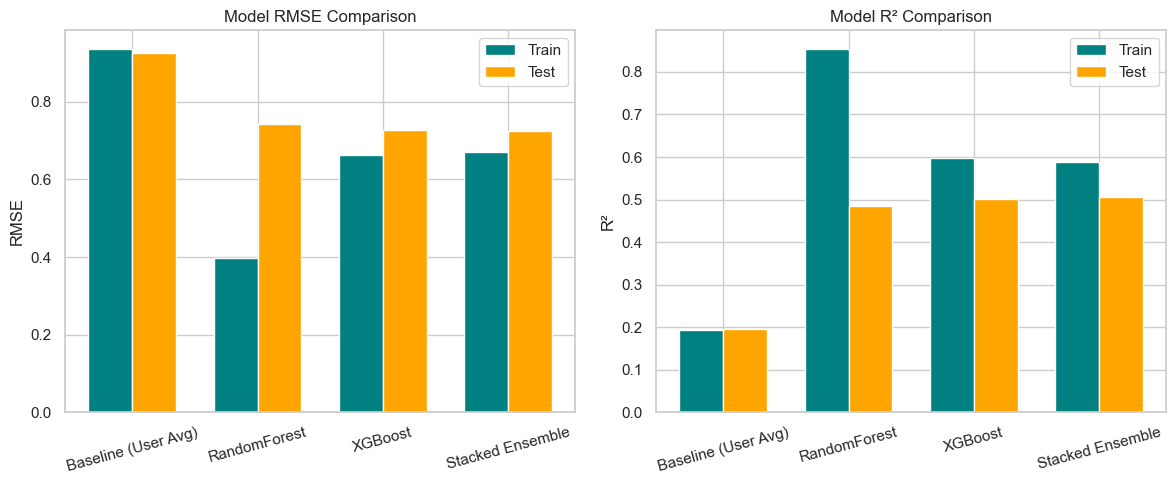

In [37]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RMSE comparison
models = results_df['model'].tolist()
x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, results_df['train_rmse'], width, label='Train', color=PALETTE_5[0])
axes[0].bar(x + width/2, results_df['test_rmse'], width, label='Test', color=PALETTE_5[2])
axes[0].set_ylabel('RMSE')
axes[0].set_title('Model RMSE Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15)
axes[0].legend()

# R² comparison
axes[1].bar(x - width/2, results_df['train_r2'], width, label='Train', color=PALETTE_5[0])
axes[1].bar(x + width/2, results_df['test_r2'], width, label='Test', color=PALETTE_5[2])
axes[1].set_ylabel('R²')
axes[1].set_title('Model R² Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=15)
axes[1].legend()

plt.tight_layout()
plt.show()

### Feature Importance

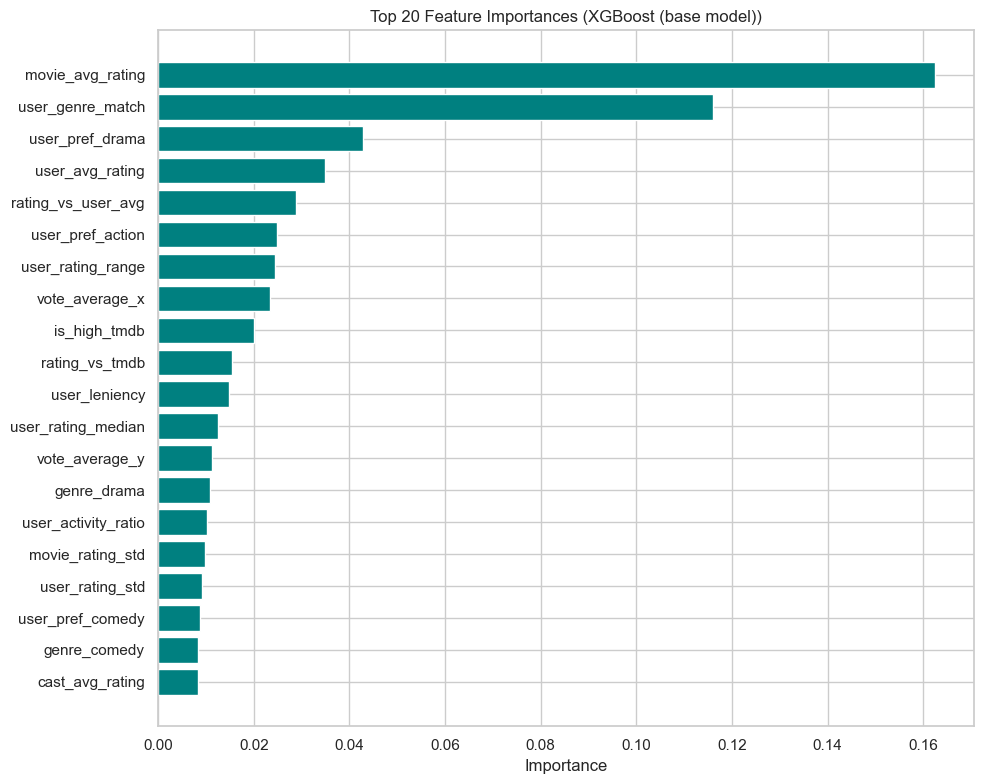


Top 10 most important features:
           feature  importance
  movie_avg_rating    0.162500
  user_genre_match    0.116130
   user_pref_drama    0.042917
   user_avg_rating    0.034882
rating_vs_user_avg    0.028814
  user_pref_action    0.024953
 user_rating_range    0.024434
    vote_average_x    0.023319
      is_high_tmdb    0.020058
    rating_vs_tmdb    0.015518


In [38]:
# Feature importance from best model (XGBoost or RandomForest)
# Stacked models don't have direct feature importance, use XGBoost as reference

if best_model_name == 'Stacked Ensemble':
    # Use XGBoost feature importance as reference for stacked model
    importances = xgb_best.feature_importances_
    importance_source = 'XGBoost (base model)'
elif best_model_name == 'XGBoost':
    best_model = xgb_best
    importances = best_model.feature_importances_
    importance_source = best_model_name
else:
    best_model = rf_best
    importances = best_model.feature_importances_
    importance_source = best_model_name

# Create importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
top_n = 20
top_features = importance_df.head(top_n)

plt.barh(top_features['feature'], top_features['importance'], color=PALETTE_5[0])
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances ({importance_source})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTop 10 most important features:")
print(importance_df.head(10).to_string(index=False))

### Prediction Analysis

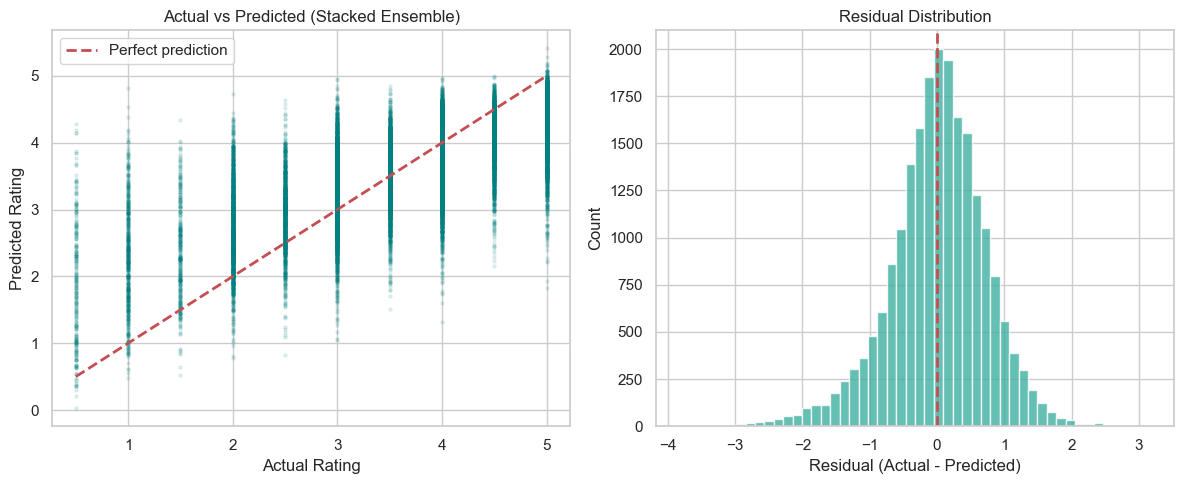

Residual statistics:
  Mean: 0.0072
  Std:  0.7252


In [39]:
# Actual vs Predicted scatter plot
if best_model_name == 'Stacked Ensemble':
    best_pred = stacked_pred
elif best_model_name == 'XGBoost':
    best_pred = xgb_pred
else:
    best_pred = rf_pred

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
axes[0].scatter(y_test, best_pred, alpha=0.1, s=5, color=PALETTE_5[0])
axes[0].plot([0.5, 5], [0.5, 5], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].set_title(f'Actual vs Predicted ({best_model_name})')
axes[0].legend()

# Residual distribution
residuals = y_test - best_pred
axes[1].hist(residuals, bins=50, color=PALETTE_5[1], edgecolor='white', alpha=0.8)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Count')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
plt.show()

print(f"Residual statistics:")
print(f"  Mean: {residuals.mean():.4f}")
print(f"  Std:  {residuals.std():.4f}")

---

## Save Model

In [40]:
# Get the best model object
if best_model_name == 'Stacked Ensemble':
    best_model = stacked_model
    best_params = {
        'base_models': ['XGBoost', 'LightGBM', 'CatBoost', 'GradientBoosting'],
        'meta_learner': 'Ridge',
        'cv': 5
    }
elif best_model_name == 'XGBoost':
    best_model = xgb_best
    best_params = xgb_grid.best_params_
else:
    best_model = rf_best
    best_params = rf_grid.best_params_

# Save best model
model_path = MODELS_DIR / 'final_model.pkl'
joblib.dump(best_model, model_path)
print(f"Saved best model ({best_model_name}) to: {model_path}")

# Save feature columns for inference
feature_cols_path = MODELS_DIR / 'feature_columns.pkl'
joblib.dump(feature_cols, feature_cols_path)
print(f"Saved feature columns to: {feature_cols_path}")

# Save model configuration
import yaml
config = {
    'model_type': best_model_name,
    'best_params': best_params,
    'metrics': {
        'test_rmse': float(results_df.loc[results_df['model'] == best_model_name, 'test_rmse'].values[0]),
        'test_mae': float(results_df.loc[results_df['model'] == best_model_name, 'test_mae'].values[0]),
        'test_r2': float(results_df.loc[results_df['model'] == best_model_name, 'test_r2'].values[0])
    },
    'n_features': len(feature_cols),
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

config_path = MODELS_DIR / 'model_config.yaml'
with open(config_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)
print(f"Saved model config to: {config_path}")

Saved best model (Stacked Ensemble) to: ../models/final_model.pkl
Saved feature columns to: ../models/feature_columns.pkl
Saved model config to: ../models/model_config.yaml


In [41]:
# Final Summary
print("=" * 60)
print("TRAINING COMPLETE")
print("=" * 60)
print(f"\nBest Model: {best_model_name}")
print(f"Test RMSE: {results_df.loc[results_df['model'] == best_model_name, 'test_rmse'].values[0]:.4f}")
print(f"Test MAE:  {results_df.loc[results_df['model'] == best_model_name, 'test_mae'].values[0]:.4f}")
print(f"Test R²:   {results_df.loc[results_df['model'] == best_model_name, 'test_r2'].values[0]:.4f}")
print(f"\nFeatures: {len(feature_cols)}")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

print(f"\nSaved files:")
print(f"  - {model_path}")
print(f"  - {feature_cols_path}")
print(f"  - {config_path}")

print("\n" + "=" * 60)
print("Ready for GA Slate Optimizer!")
print("=" * 60)

TRAINING COMPLETE

Best Model: Stacked Ensemble
Test RMSE: 0.7252
Test MAE:  0.5491
Test R²:   0.5061

Features: 100
Training samples: 85,774
Test samples: 21,444

Saved files:
  - ../models/final_model.pkl
  - ../models/feature_columns.pkl
  - ../models/model_config.yaml

Ready for GA Slate Optimizer!
